# Introduction - A Prediction:

The task in this notebook is to refine a custom model to tell apart the chext x-rays with no findings from those that have some pathology. It is a binary classification task.

Continuing from the work done in the analysis of the NIH Chest x-ray dataset here: [https://www.kaggle.com/code/naijaoracle/nih-chest-x-ray-dataset-analysis](http://) 

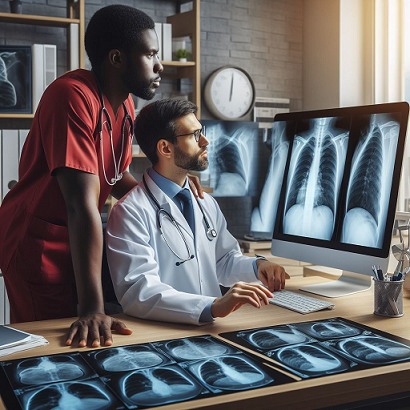

# File loading and data overview

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore', category=FutureWarning) # Suppress warnings about future library updates

In [2]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#We load the datasets into pandas dataframes

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide a default dataframe or exit the program

In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


# Data Cleaning and preprocessing

In [6]:
column_list = df.columns.tolist()
print(column_list)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


In [7]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [8]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

In [9]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
def create_disease_columns(dataframe, pathology_list):
    for pathology in pathology_list:
        dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: int(pathology in x))
    return dataframe

# Call the function with the dataframe and pathology_list
df = create_disease_columns(df, pathology_list)

In [10]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

In [11]:
# Create a boolean mask for ages greater than 100
mask = df['Patient Age'] > 100

# Use the mask to filter the DataFrame
filtered_df = df[mask]

# Get the number of rows in the filtered DataFrame
num_persons = filtered_df.shape[0]

# Create a boolean mask for ages less than or equal to 100
mask = df['Patient Age'] <= 100

# Use the mask to filter the DataFrame
df = df[mask]

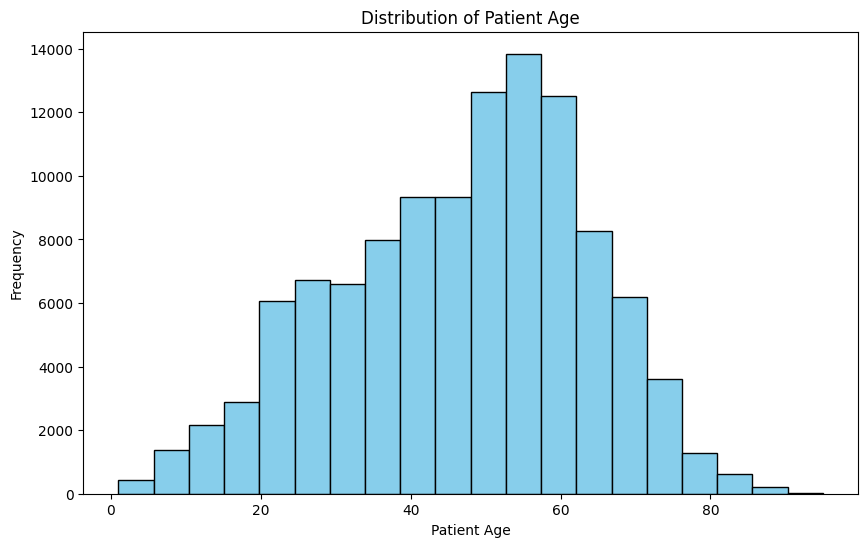

In [12]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

In [13]:
# Loop through the conditions and print their sum total in the data
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for condition in pathology_list:
    print(f"{condition}: {df[condition].sum()}")
    

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301


In [14]:
# Calculate the sum of each pathology
pathology_sums = df[pathology_list].sum()

# Calculate the sum of all pathologies except 'No Finding'
other_pathologies_sum = pathology_sums.sum() - pathology_sums['No Finding']

print(f"No Finding: {df['No Finding'].sum()}")
print(f"Other conditions: {other_pathologies_sum}")
print(f"Total: {pathology_sums.sum()}")

No Finding: 60353
Other conditions: 69606
Total: 129959


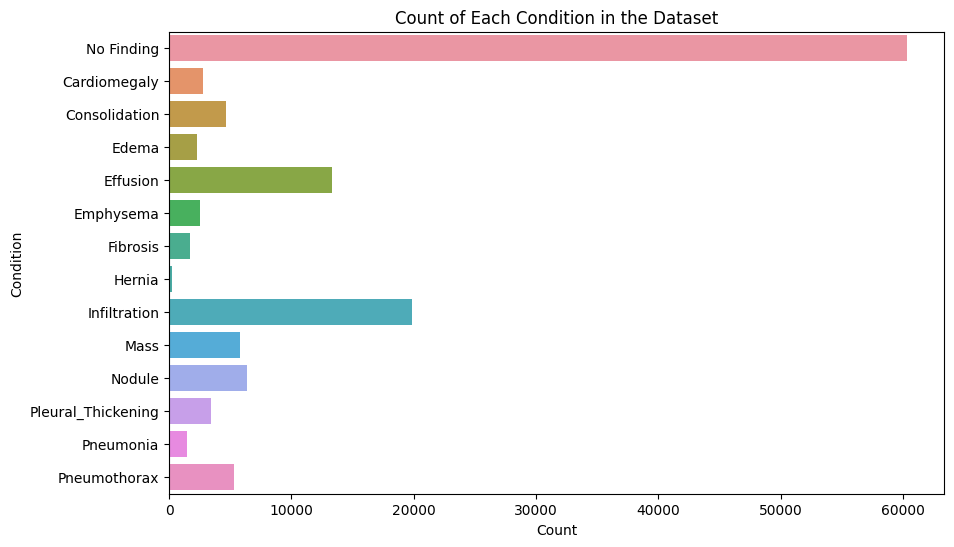

In [15]:
# Set the default palette
sns.set_palette('viridis')

# Create a list to store the counts of each condition
condition_counts = [df[pathology].sum() for pathology in pathology_list]

# Create a DataFrame from the condition counts
data = pd.DataFrame({
    'Condition': pathology_list,
    'Count': condition_counts
})

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(y='Condition', x='Count', data=data)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Count of Each Condition in the Dataset')

# Display the chart
plt.show()

## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings. 

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [16]:
# Create age groups
bins = list(range(0, 101, 10))  # Creates bins from 0 to 130 with a step of 10
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]  # Creates labels for these bins
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False)

# Calculate % of total per age group
total_patients = df.shape[0]
df_total = df['Age Group'].value_counts().sort_index() / total_patients * 100

# Calculate % of no findings per age group
df_no_findings = df[df['No Finding'] == 1].groupby('Age Group').size() / df.groupby('Age Group').size() * 100

# Combine both series into a dataframe
age_analysis_df = pd.concat([df_total, df_no_findings], axis=1)
age_analysis_df.columns = ['% of Total', '% of No Findings']

# Print the dataframe
print(age_analysis_df)

           % of Total  % of No Findings
Age Group                              
0-9          1.251516         59.871703
10-19        4.835688         58.254935
20-29       11.416185         57.462103
30-39       14.551666         58.413535
40-49       19.384679         55.851088
50-59       24.446942         51.988616
60-69       17.191180         48.988169
70-79        5.923963         47.718717
80-89        0.940198         42.884250
90-99        0.057982         38.461538


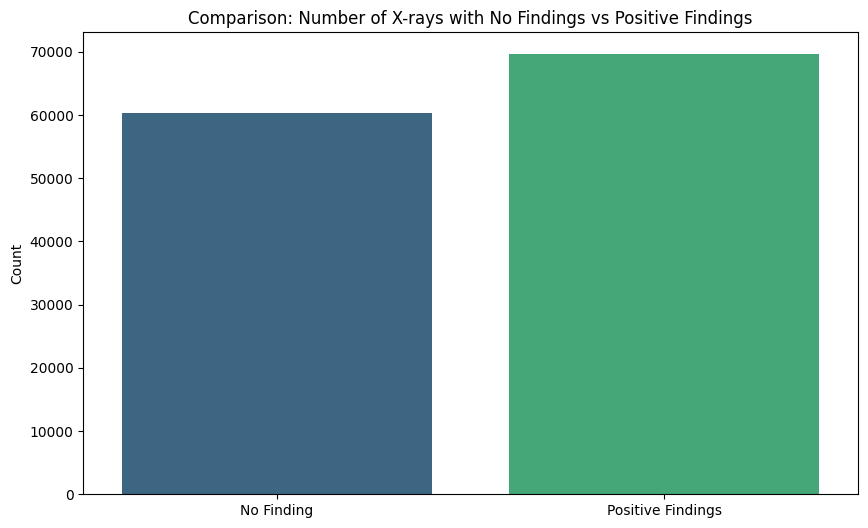

In [17]:
# Calculate the sum of each pathology
pathology_sums = df[pathology_list].sum()

# Calculate the sum of all pathologies except 'No Finding'
other_pathologies_sum = pathology_sums.sum() - pathology_sums['No Finding']

# Prepare data for the bar chart
bar_data = {'No Finding': pathology_sums['No Finding'], 'Positive Findings': other_pathologies_sum}

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(bar_data.keys()), y=list(bar_data.values()), palette='viridis')

plt.title('Comparison: Number of X-rays with No Findings vs Positive Findings')
plt.ylabel('Count')
plt.show()

In [18]:
# Load the images
root_folder = "/kaggle/input/data/"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide default paths or exit the program

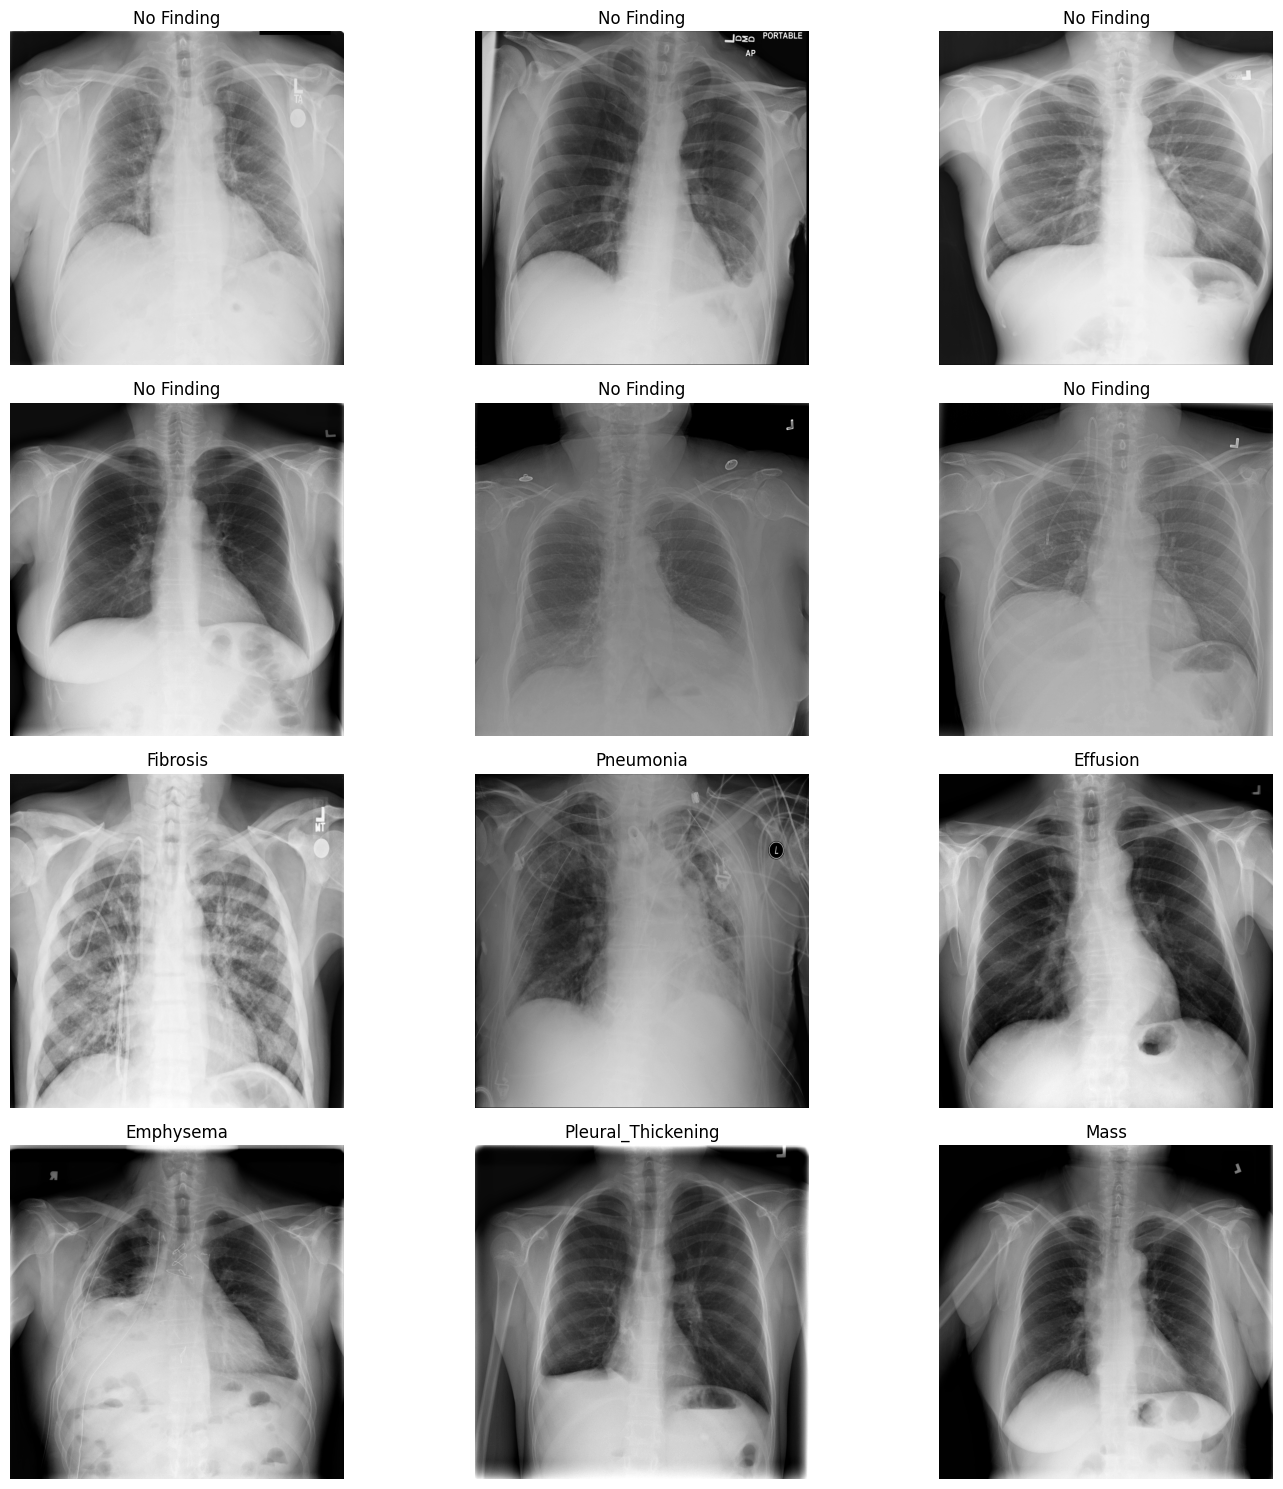

In [19]:
# Select 6 random pathologies
selected_pathologies = np.random.choice(pathology_list[1:], 6, replace=False)  # Exclude 'No Finding'

# Select one image from each selected pathology
other_pathology_images = [df[df[pathology] == 1].sample(1)['Image Index'].values[0] for pathology in selected_pathologies]

# Set aside 6 images from 'No Finding'
no_finding_images = df[df['No Finding'] == 1].sample(6)['Image Index'].values

# Now you have 6 images from 'No Finding' and 1 from each of the 6 selected pathologies
selected_images = list(no_finding_images) + other_pathology_images

image_paths_dict = {os.path.basename(path): path for path in image_paths}

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, img_name in enumerate(selected_images):
    # Load the image
    img_path = image_paths_dict[img_name]
    img = mpimg.imread(img_path)
    
    # Find the corresponding pathology
    pathology = df[df['Image Index'] == img_name][pathology_list].idxmax(axis=1).values[0]
    
    # Display the image in a subplot
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(pathology)

# Remove empty subplots
if len(selected_images) < 12:
    for i in range(len(selected_images), 12):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Machine Learning Section

In [20]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models,transforms
from torchvision.models import densenet121
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
from tqdm import tqdm

In [21]:
%%capture

def create_image_path_series(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' not found.")

    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            try:
                filepath = os.path.join(dirname, filename)
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(filepath)
            except OSError as e:
                print(f"Error processing file '{filepath}': {e}")

    return pd.Series(image_paths, index=image_paths)

# Example usage:
directory = "/kaggle/input"

try:
    image_path_series = create_image_path_series(directory)
    print(image_path_series)
except (FileNotFoundError, ValueError) as e:
    print(e)

In [22]:
# Make a copy of the dataframe
df_coded = df.copy()

# Create a new column 'target'
# If 'No Finding' is 1 then target is 0 (no condition), else target is 1 (there is a condition)
df_coded['target'] = df_coded['No Finding'].apply(lambda x: 0 if x == 1 else 1)

In [23]:
df_coded.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,target
0,00000001_000.png,0,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,0,50-59,1
1,00000001_001.png,1,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,0,50-59,1
2,00000001_002.png,2,1,58,M,0,1,0,0,1,...,0,0,0,0,0,0,0,0,50-59,1
3,00000002_000.png,0,2,81,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,80-89,0
4,00000003_000.png,0,3,81,F,0,0,0,0,0,...,0,1,0,0,0,0,0,0,80-89,1


In [24]:
df_coded['Filepath'] = image_path_series[image_paths]

In [25]:
df_coded.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,target,Filepath
0,00000001_000.png,0,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,NaN
1,00000001_001.png,1,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,NaN
2,00000001_002.png,2,1,58,M,0,1,0,0,1,...,0,0,0,0,0,0,0,50-59,1,NaN
3,00000002_000.png,0,2,81,M,1,0,0,0,0,...,0,0,0,0,0,0,0,80-89,0,NaN
4,00000003_000.png,0,3,81,F,0,0,0,0,0,...,1,0,0,0,0,0,0,80-89,1,NaN


In [26]:
# Get the absolute path of the directory
directory_path = '/kaggle/input/final10' 
file_path = os.path.join(directory_path, 'final.py')

# Add the directory to the system path 
sys.path.append(directory_path)

# Try to import the ChestXRayDataset class
try:
    from final import ChestXRayDataset
    print("Import successful.")
except Exception as e:
    print(f"Import failed with the following error: {e}")

Import successful.


In [ ]:
for index, row in tqdm(df_coded.iterrows(), total=len(df_coded)):  # Add tqdm and specify total
    filename = row['Image Index']
    for path_index, path in image_path_series.items():
        if filename in path:
            df_coded.loc[index, 'Filepath'] = path
            break

 91%|█████████▏| 102517/112104 [43:51<04:55, 32.48it/s] 

In [ ]:
df_coded.head()

In [ ]:
random_seed = 42

X = df_coded['Filepath'] 
y = df_coded['target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_seed)

X_train_df = pd.DataFrame({'Filepath': X_train, 'target': y_train})
X_val_df = pd.DataFrame({'Filepath': X_val, 'target': y_val})
X_test_df = pd.DataFrame({'Filepath': X_test, 'target': y_test})

X_train_df.reset_index(drop=True, inplace=True)
X_val_df.reset_index(drop=True, inplace=True)
X_test_df.reset_index(drop=True, inplace=True)

In [ ]:
# Load DenseNet-121 model
model = models.densenet121(pretrained=True)

# Modify the last fully connected layer for binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

In [ ]:
# Define the data transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

In [ ]:
# Select the device to run the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

In [ ]:
# Create datasets
train_dataset = ChestXRayDataset(X_train_df, transform=transform, device=device)
val_dataset = ChestXRayDataset(X_val_df, transform=transform, device=device)
test_dataset = ChestXRayDataset(X_test_df, transform=transform, device=device)

import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Model Definition

We define our dataloaders to serve the images according to our class specifications in 'custom_dataset.py'.

In [ ]:
def calculate_metrics(outputs, labels, loss_fn, threshold=0.5, zero_division=0):
    """
    Calculates and returns various metrics for a given classifier output and target labels.

    Args:
        outputs: A PyTorch tensor of model predictions, typically probabilities.
        labels: A PyTorch tensor of true target labels.
        loss_fn: A loss function (PyTorch module) used for training.
        threshold: Threshold for converting probabilities to binary predictions (default: 0.5).
        zero_division: Value to use for zero divisions in recall and F1 calculation (default: 0).

    Returns:
        A tuple containing:
            - accuracy (float): Overall accuracy of the predictions.
            - loss (float): Calculated loss based on the provided loss function.
            - precision (float): Precision score using sklearn's `precision_recall_fscore_support`.
            - recall (float): Recall score using sklearn's `precision_recall_fscore_support`.
            - f1 (float): F1 score using sklearn's `precision_recall_fscore_support`.

    Raises:
        ValueError: If `zero_division` is not a valid value (0 or 'nan').
    """
    # Convert probabilities to binary predictions using the specified threshold
    predictions = (outputs > threshold).float()

    # Calculate binary cross-entropy loss
    loss = loss_fn(outputs, labels)

    # Calculate accuracy
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.numel()

    # Move predictions and labels to CPU and convert to NumPy arrays for sklearn metrics
    predictions_np = predictions.cpu().numpy()
    labels_np = labels.cpu().numpy()

    # Use zero_division parameter in precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predictions_np, average='binary', zero_division=zero_division)

    return accuracy.item(), loss.item(), precision, recall, f1

In [ ]:
# Check for CUDA availability
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using the GPU.")
else:
    print("CUDA is not available. PyTorch is using the CPU.")

## Model training and evaluation

In [ ]:
# Define the optimizer and set the scheduler to adjust the learning rate during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True) 

# Define the loss function (criterion)
criterion = nn.BCELoss()  # Change to BCELoss for stability
#criterion = nn.BCEWithLogitsLoss()

# Define training epoch function
def train_epoch(model, train_loader, val_loader, optimizer, criterion, device, best_val_metric, epoch, num_epochs):
    model.train()
    
    # Training loop
    for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
    
    val_params = {
    'best_val_metric': best_val_metric,
    'epoch': epoch,
    'num_epochs': num_epochs,
    }

    # Validation step
    val_loss, f1, _, _ = evaluate(model, val_loader, criterion, device, val_params)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Store metrics in the dictionary
    validation_metrics['loss'].append(val_loss)
    validation_metrics['f1'].append(f1)

# Define evaluation function
def evaluate(model, data_loader, criterion, device, evaluation_params):
    best_val_metric = evaluation_params['best_val_metric']
    epoch = evaluation_params['epoch']
    num_epochs = evaluation_params['num_epochs']
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        all_predictions = []
        all_labels = []
        data_loader_iter = tqdm(data_loader, desc='Evaluation', leave=False)
        
        for inputs, labels in data_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs.squeeze(), labels.float()).item()

            all_predictions.append(outputs.detach())
            all_labels.append(labels.detach())

        total_loss /= len(data_loader)

        all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
        all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

        # Convert logits to probabilities and then to binary predictions
        probabilities = torch.sigmoid(torch.from_numpy(all_predictions)).numpy()
        threshold = 0.5
        binary_predictions = (probabilities > threshold).astype(int)

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, binary_predictions)

        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, binary_predictions, average='binary')

        print(f'Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
        return total_loss, f1, all_labels, all_predictions

num_epochs = 12
best_val_metric = float('inf')

model.to(device)

# Initialize a dictionary to store validation metrics
validation_metrics = {'loss': [], 'f1': []}

for epoch in range(num_epochs):
    train_epoch(model, train_loader, val_loader, optimizer, criterion, device, best_val_metric, epoch, num_epochs)

# Create a dictionary with the necessary parameters
test_params = {
    'best_val_metric': best_val_metric,
    'epoch': num_epochs,  # or any other value you want to use
    'num_epochs': num_epochs,
    }

# Evaluate on test set
print("Evaluating on test set:")
test_loss, test_f1, _, _ = evaluate(model, test_loader, criterion, device, test_params)

# Performance Visualisation

In [ ]:
# Visualization code
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Initialize dictionaries to store precision, recall, and average precision for each class
precision_dict = dict()
recall_dict = dict()
average_precision_dict = dict()

for i in range(14):
    precision_dict[i] = []
    recall_dict[i] = []
    average_precision_dict[i] = []

# Initialize lists to store micro-averaged precision, recall, and average precision
micro_precision_list = []
micro_recall_list = []
micro_average_precision_list = []

# Loop through epochs
for epoch in range(num_epochs):
    # Call evaluate function to get necessary information
    val_loss, f1, all_labels, all_predictions = evaluate(model, val_loader, criterion, device, best_val_metric, epoch, num_epochs)

    # Loop through each class
    for i in range(14):
        precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
        average_precision_value = average_precision_score(all_labels, all_predictions)

        # Store precision, recall, and average precision for each class
        precision_dict[i].append(precision)
        recall_dict[i].append(recall)
        average_precision_dict[i].append(average_precision_value)

        # Plot Precision-Recall curve for each class in a subplot
        axs[i // n_cols, i % n_cols].step(recall, precision, where='post')
        axs[i // n_cols, i % n_cols].set_xlabel('Recall')
        axs[i // n_cols, i % n_cols].set_ylabel('Precision')
        axs[i // n_cols, i % n_cols].set_ylim([0.0, 1.05])
        axs[i // n_cols, i % n_cols].set_xlim([0.0, 1.0])
        axs[i // n_cols, i % n_cols].set_title('Class: {}, AP={:.2f}'.format(pathology_list[i], average_precision_value))

    # Calculate micro-averaged precision, recall, and average precision
    micro_precision, micro_recall, _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
    micro_average_precision = average_precision_score(all_labels.ravel(), all_predictions.ravel(), average="micro")

    # Store micro-averaged precision, recall, and average precision
    micro_precision_list.append(micro_precision)
    micro_recall_list.append(micro_recall)
    micro_average_precision_list.append(micro_average_precision)

    # Plot micro-averaged Precision-Recall curve in a subplot
    axs[14 // n_cols, 14 % n_cols].step(micro_recall, micro_precision, where='post')
    axs[14 // n_cols, 14 % n_cols].set_xlabel('Recall')
    axs[14 // n_cols, 14 % n_cols].set_ylabel('Precision')
    axs[14 // n_cols, 14 % n_cols].set_ylim([0.0, 1.05])
    axs[14 // n_cols, 14 % n_cols].set_xlim([0.0, 1.0])
    axs[14 // n_cols, 14 % n_cols].set_title('Micro-avg, AP={:.2f}'.format(micro_average_precision))

plt.tight_layout()
plt.show()
